## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [2]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing required libraries

In [4]:
import os, gc
import random
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [6]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


## Base CapsNet

In [44]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=30
n_class=10

prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [45]:
base_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                 model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                 prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

base_capsnet_cifar10_model.name = 'base_capsnet_cifar10_model'
base_capsnet_cifar10_model = base_capsnet_cifar10_model.to(device)
base_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

### Training

In [20]:
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                base_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

02/25 05:08:11 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7510, Top 1 Acc=6.25, Top 5 Acc=56.25
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7510, Top 1 Acc=6.25, Top 5 Acc=56.25
02/25 05:08:13 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6117, Top 1 Acc=18.56, Top 5 Acc=63.54
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6117, Top 1 Acc=18.56, Top 5 Acc=63.54
02/25 05:08:15 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5723, Top 1 Acc=19.81, Top 5 Acc=65.67
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5723, Top 1 Acc=19.81, Top 5 Acc=65.67
02/25 05:08:17 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5501, Top 1 Acc=21.78, Top 5 Acc=67.78
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0

### Plots for losses and accuracies

In [21]:
base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = base_capsnet_cifar10_model['epoch_accuracy']

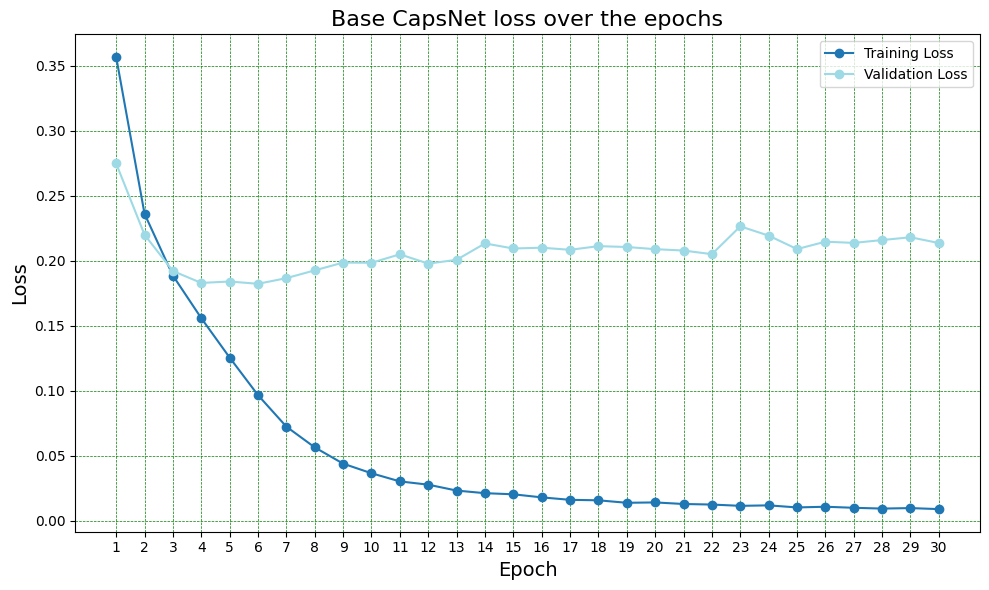

In [22]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Base CapsNet loss over the epochs')

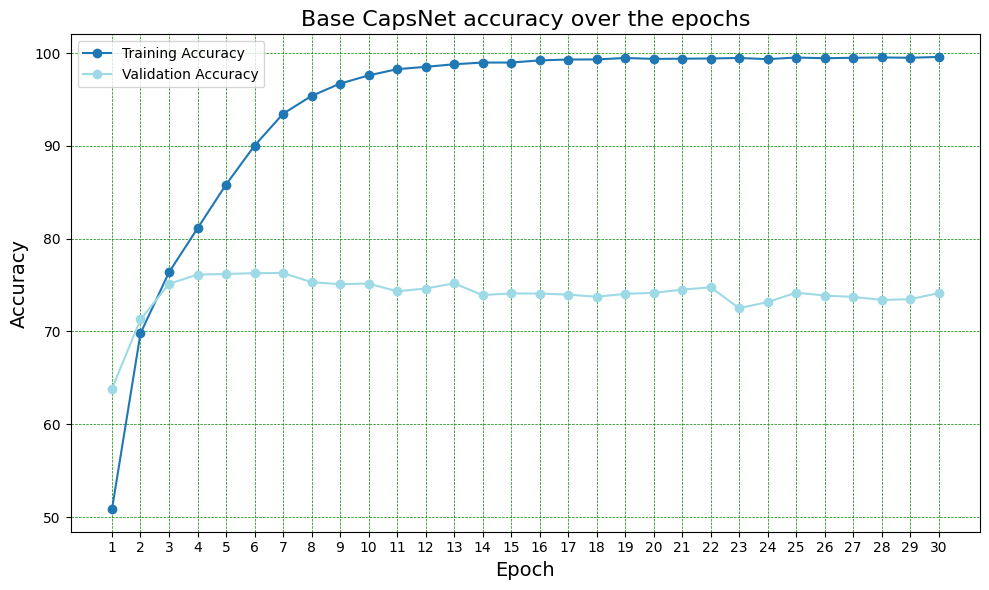

In [23]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Base CapsNet accuracy over the epochs')

### Training with CCM loss

CCM alpha = 0.01

In [7]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=30
n_class=10

prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:13<00:00, 12819767.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

In [26]:
%%time
best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                      base_capsnet_cifar10_ccm_model,
                                                      criterion,
                                                      train_loader,
                                                      test_loader,
                                                      CIFAR10_TRAIN_DIR,
                                                      logger,
                                                      calc_ccm=True,
                                                      device=device)

02/25 06:00:19 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=0.0384, Top 1 Acc=96.88, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=0.0384, Top 1 Acc=96.88, Top 5 Acc=100.00
02/25 06:00:21 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=0.0376, Top 1 Acc=95.93, Top 5 Acc=99.81
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=0.0376, Top 1 Acc=95.93, Top 5 Acc=99.81
02/25 06:00:23 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=0.0369, Top 1 Acc=95.62, Top 5 Acc=99.90
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=0.0369, Top 1 Acc=95.62, Top 5 Acc=99.90
02/25 06:00:25 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(96/1563), Loss=0.0356, Top 1 Acc=96.17, Top 5 Acc=99.94
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - 

CPU times: user 51min 3s, sys: 3min 9s, total: 54min 12s
Wall time: 54min 50s


Training with CCM loss with alpha=0.05

In [9]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

In [11]:
%%time
n_epochs=15
ccm_alpha=0.05
CIFAR10_TRAIN_DIR=TRAIN_DIR+"cifar10/16Caps12Dim/alpha005/"

best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                      base_capsnet_cifar10_ccm_model,
                                                      criterion,
                                                      train_loader,
                                                      test_loader,
                                                      CIFAR10_TRAIN_DIR,
                                                      logger,
                                                      ccm_alpha=ccm_alpha,
                                                      calc_ccm=True,
                                                      device=device)

02/25 08:56:35 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=-0.0114, Top 1 Acc=96.88, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=-0.0114, Top 1 Acc=96.88, Top 5 Acc=100.00
02/25 08:56:37 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=-0.0151, Top 1 Acc=95.93, Top 5 Acc=99.91
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=-0.0151, Top 1 Acc=95.93, Top 5 Acc=99.91
02/25 08:56:39 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=-0.0194, Top 1 Acc=96.25, Top 5 Acc=99.90
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=-0.0194, Top 1 Acc=96.25, Top 5 Acc=99.90
02/25 08:56:41 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(96/1563), Loss=-0.0216, Top 1 Acc=96.52, Top 5 Acc=99.94
INFO:capsnet:base_capsnet_cifar10_ccm_model Trai

CPU times: user 25min 33s, sys: 1min 35s, total: 27min 9s
Wall time: 27min 35s


Training with CCM loss with alpha=0.1

In [48]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

In [49]:
%%time
n_epochs=15
ccm_alpha=0.1
CIFAR10_TRAIN_DIR=TRAIN_DIR+"cifar10/16Caps12Dim/alpha010/"

best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                      base_capsnet_cifar10_ccm_model,
                                                      criterion,
                                                      train_loader,
                                                      test_loader,
                                                      CIFAR10_TRAIN_DIR,
                                                      logger,
                                                      ccm_alpha=ccm_alpha,
                                                      calc_ccm=True,
                                                      device=device)

02/25 07:28:27 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=-0.0870, Top 1 Acc=100.00, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=-0.0870, Top 1 Acc=100.00, Top 5 Acc=100.00
02/25 07:28:31 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=-0.0936, Top 1 Acc=96.88, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=-0.0936, Top 1 Acc=96.88, Top 5 Acc=100.00
02/25 07:28:35 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=-0.0951, Top 1 Acc=96.49, Top 5 Acc=99.95
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=-0.0951, Top 1 Acc=96.49, Top 5 Acc=99.95
02/25 07:28:37 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(96/1563), Loss=-0.0948, Top 1 Acc=96.17, Top 5 Acc=99.90
INFO:capsnet:base_capsnet_cifar10_ccm_model 

CPU times: user 25min 50s, sys: 1min 35s, total: 27min 25s
Wall time: 27min 44s


Training with CCM loss with alpha=0.005

In [50]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

In [51]:
%%time
n_epochs=15
ccm_alpha=0.005
CIFAR10_TRAIN_DIR=TRAIN_DIR+"cifar10/16Caps12Dim/alpha0005/"

best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                      base_capsnet_cifar10_ccm_model,
                                                      criterion,
                                                      train_loader,
                                                      test_loader,
                                                      CIFAR10_TRAIN_DIR,
                                                      logger,
                                                      ccm_alpha=ccm_alpha,
                                                      calc_ccm=True,
                                                      device=device)

02/25 07:56:11 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=0.0435, Top 1 Acc=96.88, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=0.0435, Top 1 Acc=96.88, Top 5 Acc=100.00
02/25 07:56:14 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=0.0408, Top 1 Acc=96.21, Top 5 Acc=99.91
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=0.0408, Top 1 Acc=96.21, Top 5 Acc=99.91
02/25 07:56:16 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=0.0408, Top 1 Acc=96.44, Top 5 Acc=99.95
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=0.0408, Top 1 Acc=96.44, Top 5 Acc=99.95
02/25 07:56:18 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(96/1563), Loss=0.0406, Top 1 Acc=96.52, Top 5 Acc=99.94
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - 

CPU times: user 25min 48s, sys: 1min 34s, total: 27min 22s
Wall time: 27min 37s


Training with CCM loss with alpha=0.001

In [52]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

In [53]:
%%time
n_epochs=15
ccm_alpha=0.001
CIFAR10_TRAIN_DIR=TRAIN_DIR+"cifar10/16Caps12Dim/alpha0001/"

best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                      base_capsnet_cifar10_ccm_model,
                                                      criterion,
                                                      train_loader,
                                                      test_loader,
                                                      CIFAR10_TRAIN_DIR,
                                                      logger,
                                                      ccm_alpha=ccm_alpha,
                                                      calc_ccm=True,
                                                      device=device)

02/25 08:23:49 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=0.0348, Top 1 Acc=96.88, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=0.0348, Top 1 Acc=96.88, Top 5 Acc=100.00
02/25 08:23:51 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=0.0534, Top 1 Acc=95.74, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=0.0534, Top 1 Acc=95.74, Top 5 Acc=100.00
02/25 08:23:54 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=0.0479, Top 1 Acc=96.73, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=0.0479, Top 1 Acc=96.73, Top 5 Acc=100.00
02/25 08:23:56 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(96/1563), Loss=0.0485, Top 1 Acc=96.75, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Traini

CPU times: user 27min 25s, sys: 1min 36s, total: 29min 2s
Wall time: 29min 20s


In [ ]:
time.sleep(10)

from google.colab import runtime
runtime.unassign()

### CCM and CI score calculation

In [12]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_ccm_model.pt',
                                                 map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

Extract Correlation Coefficient Matrix

In [13]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_layers = 4
layer_ccm_list = [ [] for _ in range(n_layers) ]
layer_mean_ccm_list = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            _, batch_ccm = ccmp.calc_ccm_loss(batch_feature_maps)
            layer_ccm_list[indx].append(batch_ccm.detach().cpu())

        torch.cuda.empty_cache()

for i in range(n_layers):
    layer_mean_ccm_list.append(torch.mean(torch.stack(layer_ccm_list[i]), dim=0))

ccmp.save_ccm(layer_mean_ccm_list, CIFAR10_TRAIN_DIR, base_capsnet_cifar10_ccm_model.name+'_ccm')

base_capsnet_cifar10_ccm_model_ccm saved
CPU times: user 25.4 s, sys: 6.93 s, total: 32.3 s
Wall time: 33.4 s


Channel Importance Scores

In [14]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_layers = 4
layer_ci_list = [ [] for _ in range(n_layers) ]

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            batch_ci_score = ccmp.ci_score(batch_feature_maps)
            layer_ci_list[indx].append(batch_ci_score.detach().cpu().numpy())

        torch.cuda.empty_cache()

    layer_mean_ci_list = []

    for i in range(n_layers):
        layer_mean_ci_list.append(np.mean(layer_ci_list[i], axis=0))

    np.save(CIFAR10_TRAIN_DIR+base_capsnet_cifar10_ccm_model.name+'_ci_scores.npy', np.asarray(layer_mean_ci_list, dtype=object))

CPU times: user 54min 46s, sys: 8.44 s, total: 54min 54s
Wall time: 55min 3s


### Pruning

In [29]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=30
n_class=10

prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
pretrained_base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                model_conv_config=model_conv_config,
                                                                prim_caps_channels=prim_caps_channels,
                                                                prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_ccm_model.pt',
                                                 map_location=device)

pretrained_base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

pretrained_base_capsnet_cifar10_ccm_model = pretrained_base_capsnet_cifar10_ccm_model.to(device)
pretrained_base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

In [10]:
layers_to_prune_dict = {'conv_layer_1':0,
                        'conv_layer_2':1,
                        'conv_layer_3':2,
                        'primary_caps':3 }

base_capsnet_cifar10_ccm_model_ci_scores = np.load(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_ccm_model_ci_scores.npy', allow_pickle=True)
#base_capsnet_cifar10_ccm_model_ccm = ccmp.load_ccm(CIFAR10_TRAIN_DIR, 'base_capsnet_cifar10_ccm_model_ccm')

#### 12.5% Pruning

In [46]:
prune_threshold = 0.125

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_12pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_12pc_base_capsnet_cifar10_model.name = 'pruned_12pc_base_capsnet_cifar10_model'
pruned_12pc_base_capsnet_cifar10_model = pruned_12pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 84, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(84, 168, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(168, 168, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [19]:
%%time
best_pruned_12pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_12pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/25 10:19:50 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=1.7662, Top 1 Acc=6.25, Top 5 Acc=53.12
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=1.7662, Top 1 Acc=6.25, Top 5 Acc=53.12
02/25 10:19:52 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8475, Top 1 Acc=15.06, Top 5 Acc=58.05
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8475, Top 1 Acc=15.06, Top 5 Acc=58.05
02/25 10:19:54 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7010, Top 1 Acc=18.85, Top 5 Acc=62.84
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7010, Top 1 Acc=18.85, Top 5 Acc=62.84
02/25 10:19:56 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.6474, Top 1 Acc=20.26, Top 5 Acc=65.79
INF

CPU times: user 51min 26s, sys: 3min 8s, total: 54min 34s
Wall time: 55min 10s


##### Plots for losses and accuracies

In [20]:
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_12pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_12pc_base_capsnet_cifar10_model['epoch_accuracy']

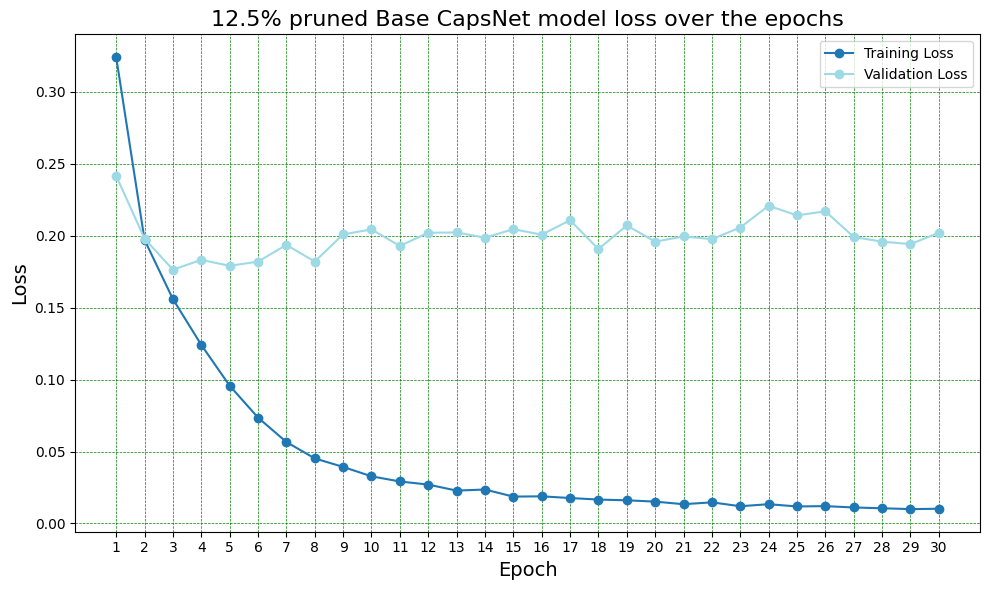

In [21]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '12.5% pruned Base CapsNet model loss over the epochs')

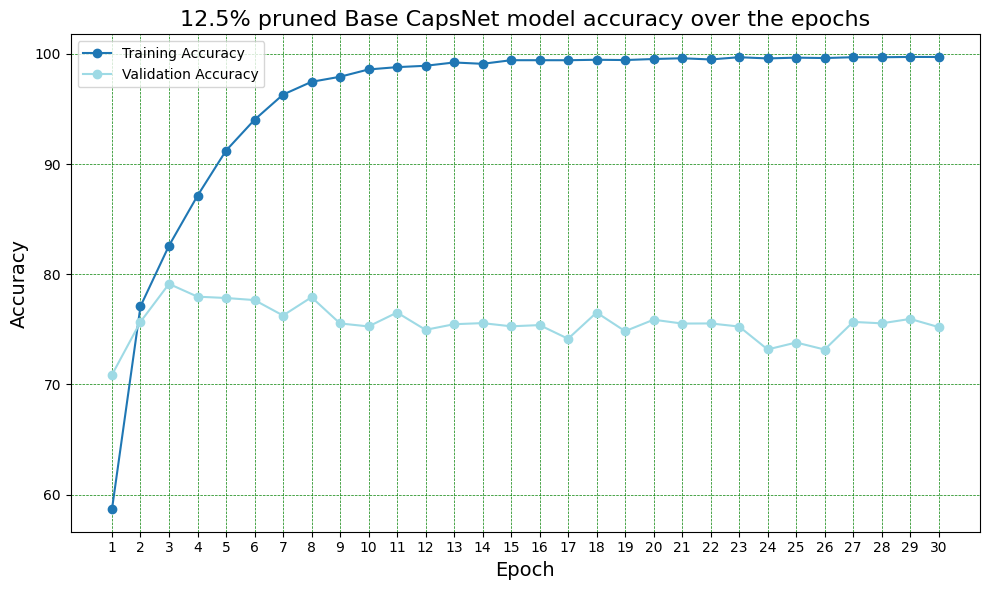

In [22]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '12.5% pruned Base CapsNet model accuracy over the epochs')

In [ ]:
# print("training is complete")

# time.sleep(10)
# print("Unassigning runtime")

# from google.colab import runtime
# runtime.unassign()

training is complete
Unassigning runtime


#### 25% Pruning

In [47]:
prune_threshold = 0.25

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_25pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_25pc_base_capsnet_cifar10_model.name = 'pruned_25pc_base_capsnet_cifar10_model'
pruned_25pc_base_capsnet_cifar10_model = pruned_25pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [24]:
%%time
best_pruned_25pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_25pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/25 11:15:02 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=1.4722, Top 1 Acc=18.75, Top 5 Acc=56.25
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=1.4722, Top 1 Acc=18.75, Top 5 Acc=56.25
02/25 11:15:04 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7638, Top 1 Acc=15.81, Top 5 Acc=58.14
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7638, Top 1 Acc=15.81, Top 5 Acc=58.14
02/25 11:15:07 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6495, Top 1 Acc=19.23, Top 5 Acc=65.00
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6495, Top 1 Acc=19.23, Top 5 Acc=65.00
02/25 11:15:09 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5910, Top 1 Acc=23.78, Top 5 Acc=69.10
I

CPU times: user 51min 16s, sys: 3min 12s, total: 54min 28s
Wall time: 55min 6s


##### Plots for losses and accuracies

In [25]:
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_accuracy']

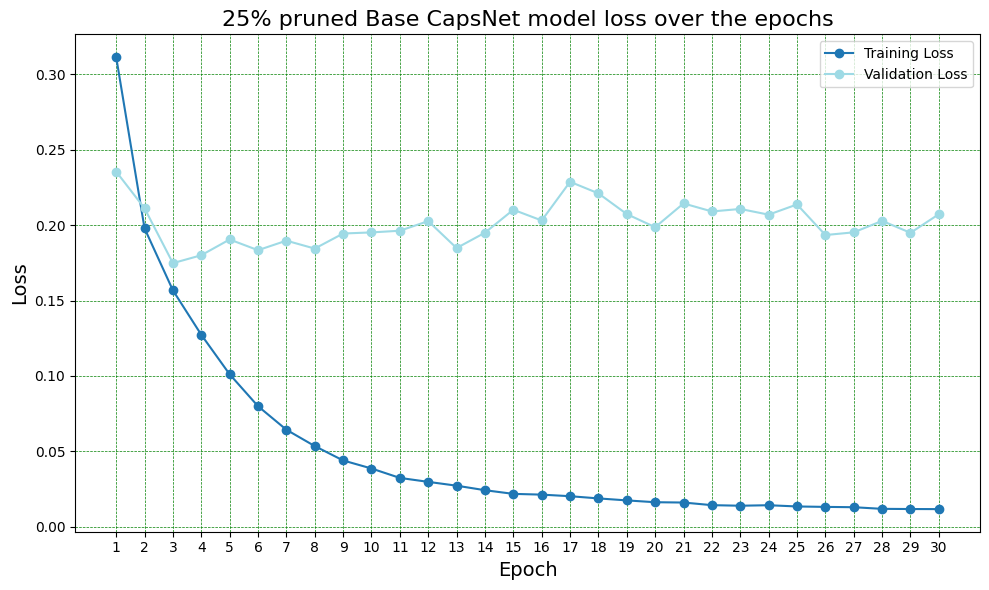

In [26]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% pruned Base CapsNet model loss over the epochs')

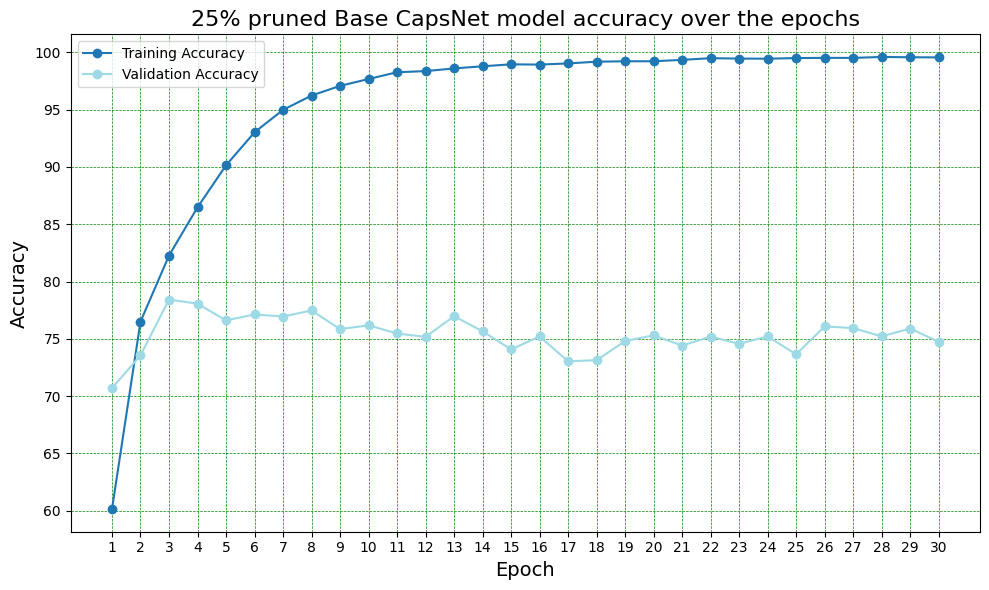

In [27]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% pruned Base CapsNet model accuracy over the epochs')

#### 37.5% Pruning

In [48]:
prune_threshold = 0.375

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_37pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_37pc_base_capsnet_cifar10_model.name = 'pruned_37pc_base_capsnet_cifar10_model'
pruned_37pc_base_capsnet_cifar10_model = pruned_37pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [29]:
%%time
best_pruned_37pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_37pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/26 12:10:10 AM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=1.1616, Top 1 Acc=9.38, Top 5 Acc=62.50
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=1.1616, Top 1 Acc=9.38, Top 5 Acc=62.50
02/26 12:10:13 AM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6716, Top 1 Acc=16.19, Top 5 Acc=60.51
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6716, Top 1 Acc=16.19, Top 5 Acc=60.51
02/26 12:10:15 AM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5964, Top 1 Acc=20.05, Top 5 Acc=66.15
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5964, Top 1 Acc=20.05, Top 5 Acc=66.15
02/26 12:10:17 AM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5608, Top 1 Acc=22.71, Top 5 Acc=69.81
INF

CPU times: user 49min 1s, sys: 3min 6s, total: 52min 8s
Wall time: 52min 39s


##### Plots for losses and accuracies

In [30]:
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_37pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_37pc_base_capsnet_cifar10_model['epoch_accuracy']

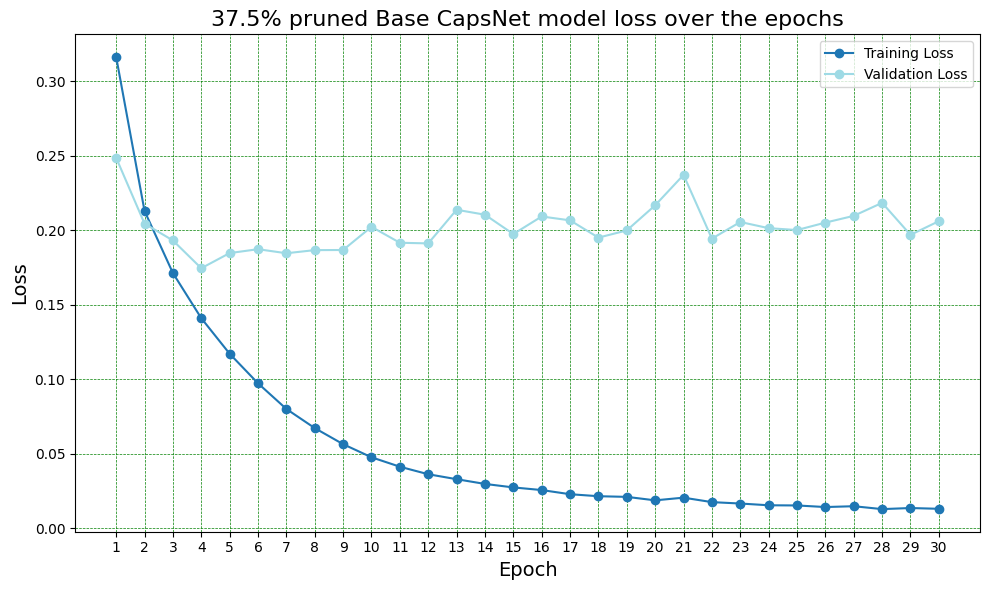

In [31]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% pruned Base CapsNet model loss over the epochs')

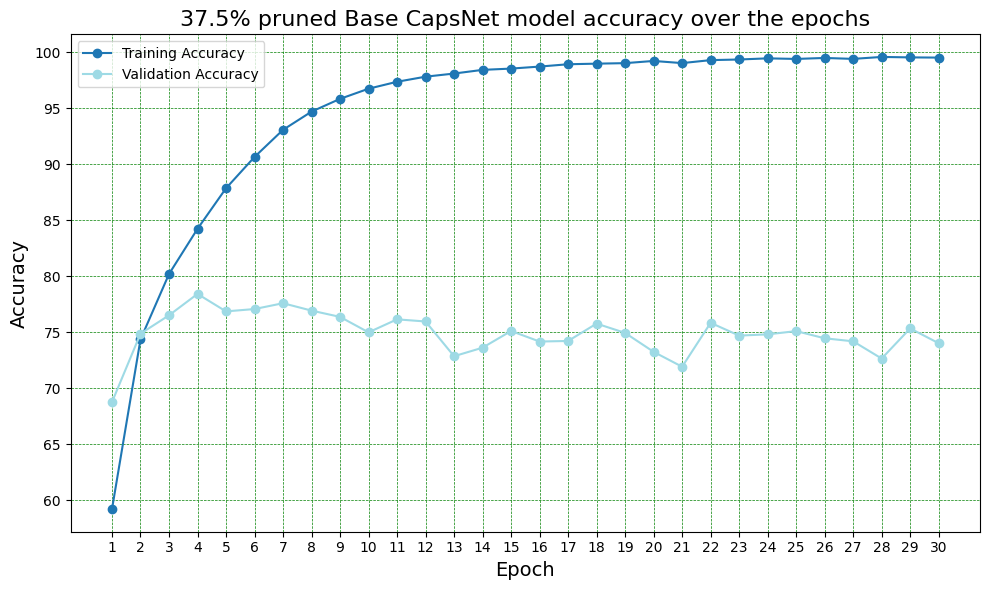

In [32]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],'Epoch', 'Accuracy',
                      '37.5% pruned Base CapsNet model accuracy over the epochs')

#### 50% Pruning

In [49]:
prune_threshold = 0.50

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_50pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_50pc_base_capsnet_cifar10_model.name = 'pruned_50pc_base_capsnet_cifar10_model'
pruned_50pc_base_capsnet_cifar10_model = pruned_50pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [34]:
%%time
best_pruned_50pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_50pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/26 01:02:51 AM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.9300, Top 1 Acc=12.50, Top 5 Acc=40.62
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.9300, Top 1 Acc=12.50, Top 5 Acc=40.62
02/26 01:02:53 AM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6079, Top 1 Acc=18.94, Top 5 Acc=59.66
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6079, Top 1 Acc=18.94, Top 5 Acc=59.66
02/26 01:02:56 AM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5480, Top 1 Acc=24.09, Top 5 Acc=67.45
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5480, Top 1 Acc=24.09, Top 5 Acc=67.45
02/26 01:02:58 AM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5089, Top 1 Acc=29.67, Top 5 Acc=72.87
I

CPU times: user 46min 22s, sys: 3min 4s, total: 49min 26s
Wall time: 49min 55s


##### Plots for losses and accuracies

In [11]:
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_accuracy']

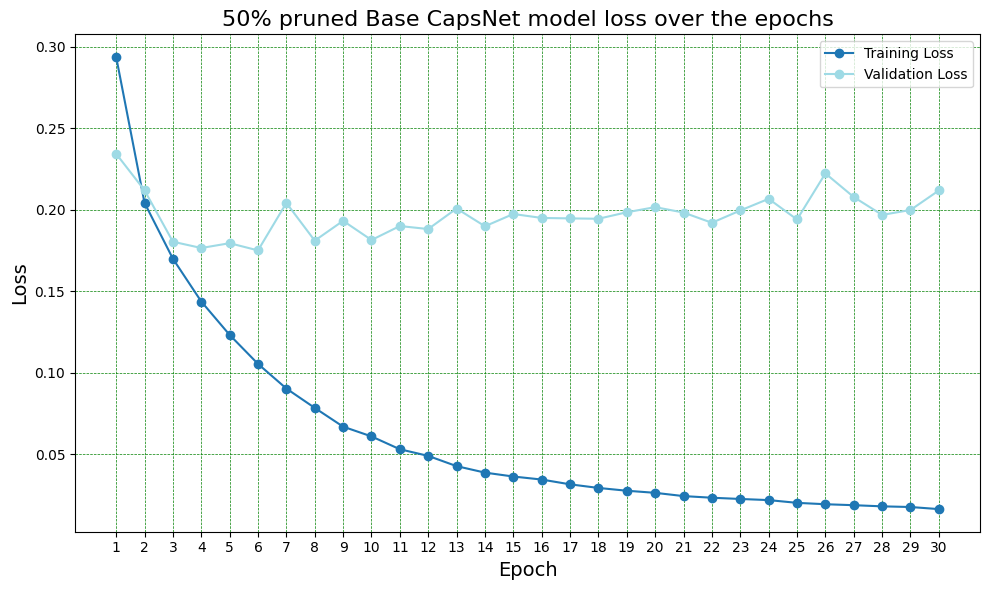

In [12]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '50% pruned Base CapsNet model loss over the epochs')

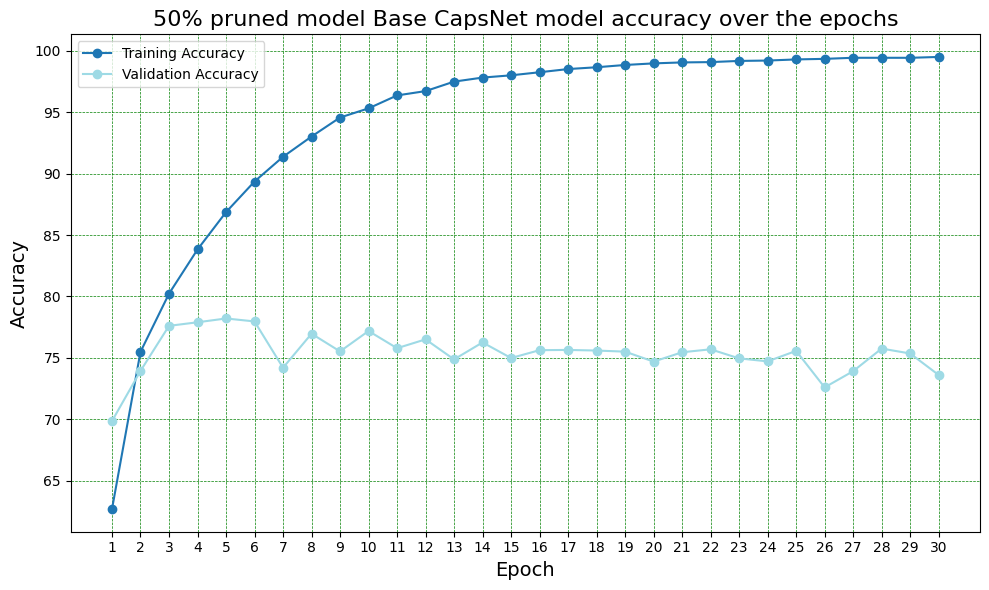

In [13]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '50% pruned model Base CapsNet model accuracy over the epochs')

#### 62.5% Pruning

In [50]:
prune_threshold = 0.625

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_62pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_62pc_base_capsnet_cifar10_model.name = 'pruned_62pc_base_capsnet_cifar10_model'
pruned_62pc_base_capsnet_cifar10_model = pruned_62pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [15]:
%%time
best_pruned_62pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_62pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/26 03:26:55 AM | pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.6822, Top 1 Acc=3.12, Top 5 Acc=40.62
INFO:capsnet:pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.6822, Top 1 Acc=3.12, Top 5 Acc=40.62
02/26 03:26:56 AM | pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5360, Top 1 Acc=20.74, Top 5 Acc=65.06
INFO:capsnet:pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5360, Top 1 Acc=20.74, Top 5 Acc=65.06
02/26 03:26:58 AM | pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4962, Top 1 Acc=27.93, Top 5 Acc=72.74
INFO:capsnet:pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4962, Top 1 Acc=27.93, Top 5 Acc=72.74
02/26 03:27:00 AM | pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4698, Top 1 Acc=32.96, Top 5 Acc=76.93
INF

KeyboardInterrupt: 

Checkpoint Restart

In [37]:
%%time
n_epochs = 30
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch30_of_30.pt'

best_pruned_62pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_62pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device,
                                                             checkpoint_file=checkpoint_file)

02/26 03:35:43 AM | pruned_62pc_base_capsnet_cifar10_model best accuracy=77.020 saved at: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/16Caps12Dim/Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch7_of_30.pt
INFO:capsnet:pruned_62pc_base_capsnet_cifar10_model best accuracy=77.020 saved at: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/16Caps12Dim/Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch7_of_30.pt


CPU times: user 29.2 ms, sys: 17.6 ms, total: 46.8 ms
Wall time: 1.84 s


#####Plots for losses and accuracies

In [38]:
trained_pruned_62pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_62pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_62pc_base_capsnet_cifar10_model['epoch_accuracy']

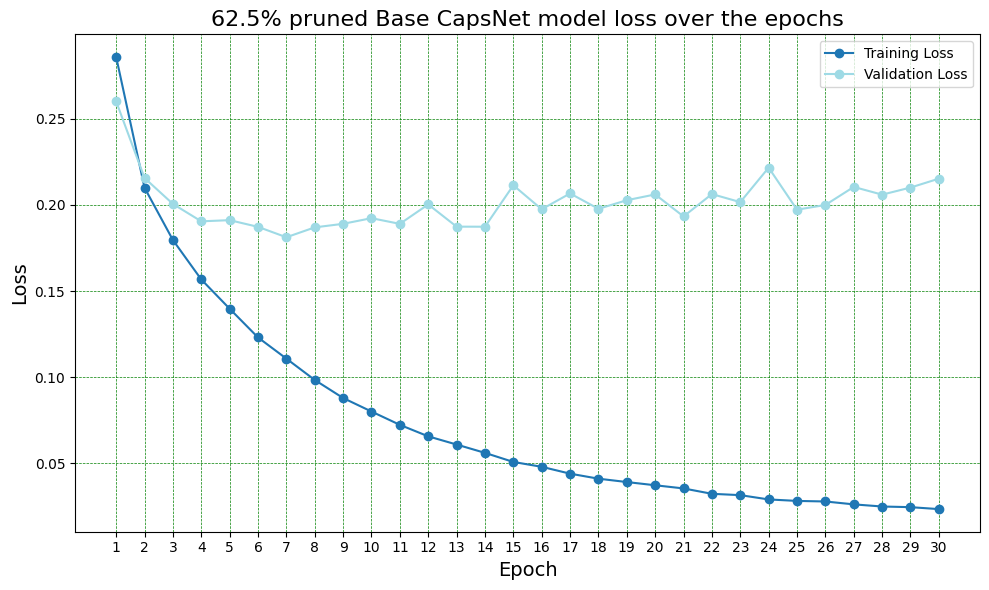

In [39]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '62.5% pruned Base CapsNet model loss over the epochs')

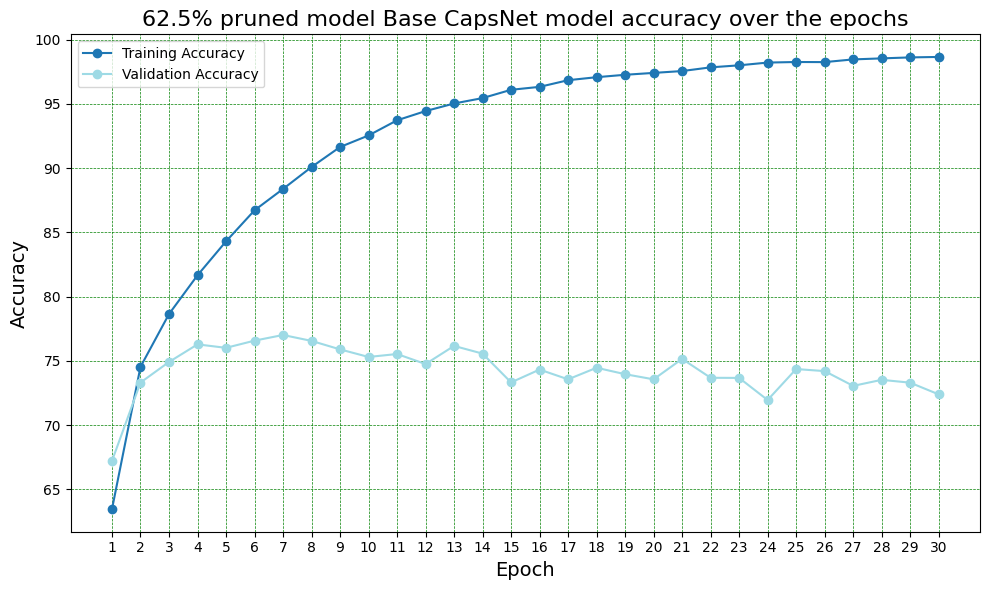

In [40]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '62.5% pruned model Base CapsNet model accuracy over the epochs')

#### 75% Pruning

In [51]:
prune_threshold = 0.75

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_75pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_75pc_base_capsnet_cifar10_model.name = 'pruned_75pc_base_capsnet_cifar10_model'
pruned_75pc_base_capsnet_cifar10_model = pruned_75pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [20]:
%%time
pruned_75pc_base_capsnet_cifar10_model, _, _ = mtt.train_capsnet(n_epochs,
                                                                 pruned_75pc_base_capsnet_cifar10_model,
                                                                 criterion,
                                                                 train_loader,
                                                                 test_loader,
                                                                 CIFAR10_TRAIN_DIR,
                                                                 logger,
                                                                 device=device)

02/26 03:27:59 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.5227, Top 1 Acc=18.75, Top 5 Acc=56.25
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.5227, Top 1 Acc=18.75, Top 5 Acc=56.25
02/26 03:28:00 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.4838, Top 1 Acc=26.99, Top 5 Acc=73.11
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.4838, Top 1 Acc=26.99, Top 5 Acc=73.11
02/26 03:28:02 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4623, Top 1 Acc=32.21, Top 5 Acc=76.88
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4623, Top 1 Acc=32.21, Top 5 Acc=76.88
02/26 03:28:03 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4425, Top 1 Acc=36.05, Top 5 Acc=79.67
I

KeyboardInterrupt: 

Checkpoint Restart

In [31]:
%%time
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch29_of_30.pt'

pruned_75pc_base_capsnet_cifar10_model, _, _ = mtt.train_capsnet(n_epochs,
                                                                 pruned_75pc_base_capsnet_cifar10_model,
                                                                 criterion,
                                                                 train_loader,
                                                                 test_loader,
                                                                 CIFAR10_TRAIN_DIR,
                                                                 logger,
                                                                 device=device,
                                                                 checkpoint_file=checkpoint_file)

02/26 03:31:55 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=30, Iteration=(0/1563), Loss=0.0232, Top 1 Acc=96.88, Top 5 Acc=100.00
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=30, Iteration=(0/1563), Loss=0.0232, Top 1 Acc=96.88, Top 5 Acc=100.00
02/26 03:31:57 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=30, Iteration=(32/1563), Loss=0.0334, Top 1 Acc=97.73, Top 5 Acc=100.00
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=30, Iteration=(32/1563), Loss=0.0334, Top 1 Acc=97.73, Top 5 Acc=100.00
02/26 03:31:59 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=30, Iteration=(64/1563), Loss=0.0341, Top 1 Acc=97.64, Top 5 Acc=100.00
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=30, Iteration=(64/1563), Loss=0.0341, Top 1 Acc=97.64, Top 5 Acc=100.00
02/26 03:32:01 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=30, Iteration=(96/1563), Loss=0.0334, Top 1 Acc=97.52, Top 

CPU times: user 1min 23s, sys: 6.51 s, total: 1min 29s
Wall time: 1min 36s


#####Plots for losses and accuracies

In [21]:
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_75pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_75pc_base_capsnet_cifar10_model['epoch_accuracy']

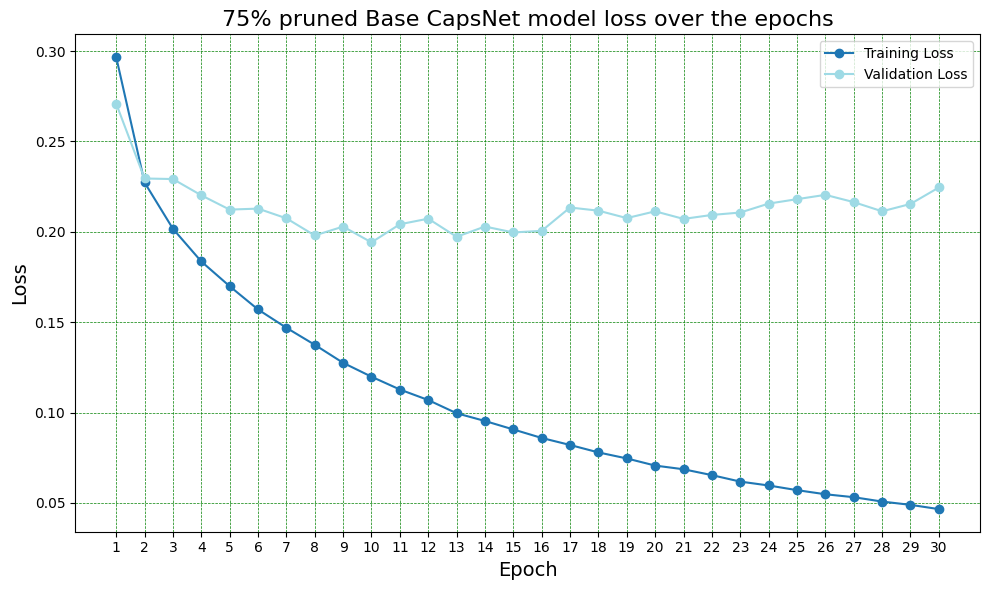

In [22]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '75% pruned Base CapsNet model loss over the epochs')

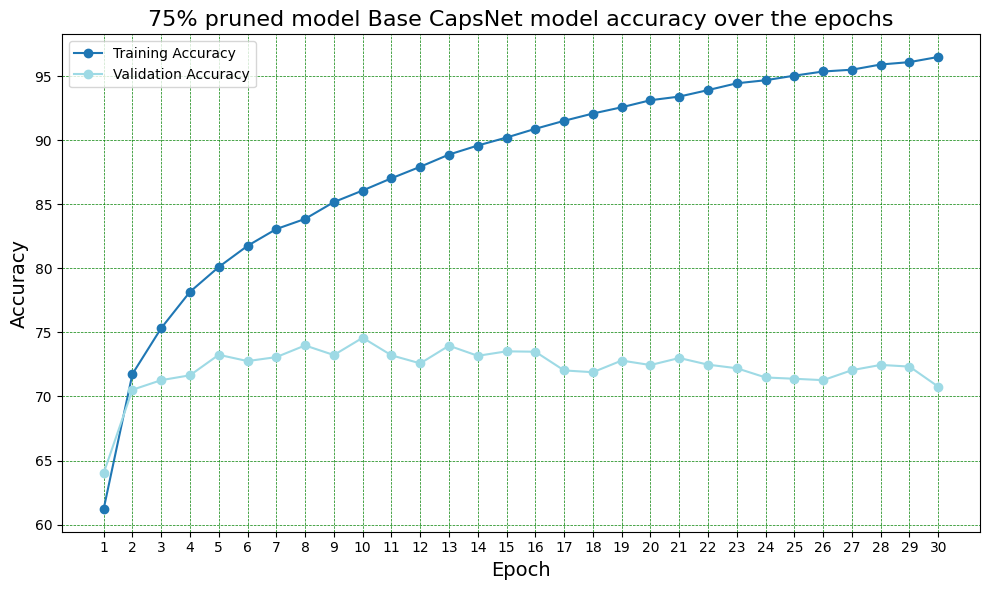

In [23]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '75% pruned model Base CapsNet model accuracy over the epochs')

#### Plots for Unpruned and Pruned CapsNet

In [34]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_62pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_62pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 30

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][1]

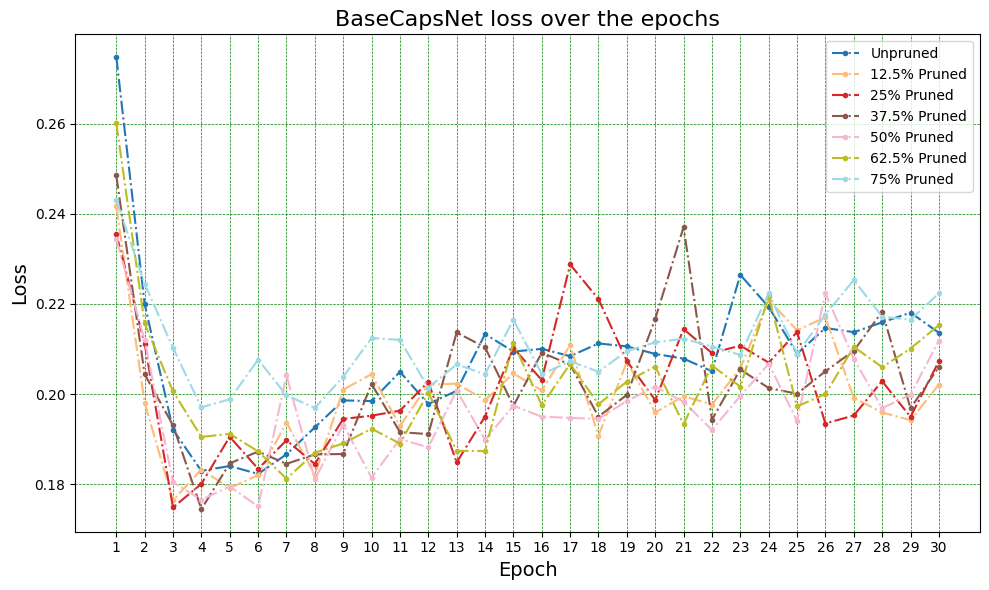

In [35]:
utils.plot_line_chart(epoch_losses, ['Unpruned', '12.5% Pruned', '25% Pruned', '37.5% Pruned', '50% Pruned', '62.5% Pruned', '75% Pruned'],
                      'Epoch', 'Loss', 'BaseCapsNet loss over the epochs', marker='.', line='-.')

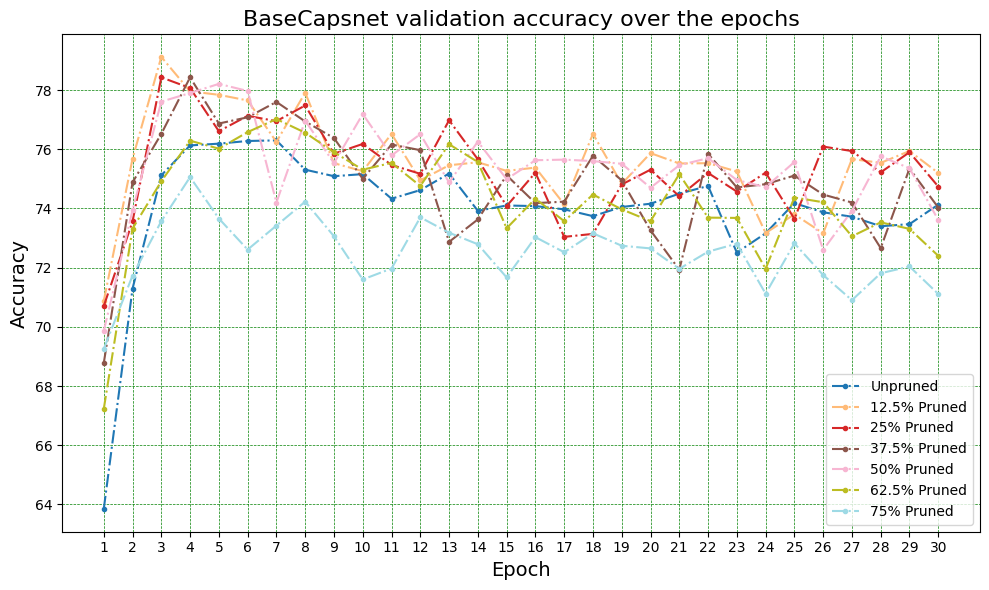

In [36]:
utils.plot_line_chart(epoch_accuracies, ['Unpruned', '12.5% Pruned', '25% Pruned', '37.5% Pruned', '50% Pruned', '62.5% Pruned', '75% Pruned'],
                      'Epoch', 'Accuracy', 'BaseCapsnet validation accuracy over the epochs', marker='.', line='-.')

#### Flops and Params Count

In [41]:
def count_class_caps_ops(m, x, y: torch.Tensor):
    x = x[0]
    x = x.view(x.size(0), x.size(1), 1, x.size(2), 1)

    count_mat = vision.calc_func.counter_matmul(m.weights.shape, x.shape)
    m.total_ops += count_mat

In [42]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)

custom_ops = {caps.CapsLayer : count_class_caps_ops}

In [52]:
base_capsnet_cifar10_model.eval()

flops, params = profile(base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 Flops = {}".format(base_capsnet_cifar10_model.name, flops))
print("{} CIFAR10 Params = {}".format(base_capsnet_cifar10_model.name, params))

base_capsnet_cifar10_model CIFAR10 Flops = 72.665M
base_capsnet_cifar10_model CIFAR10 Params = 2.047M


In [53]:
prune_threshold = 0.125
pruned_12pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_12pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Flops = 54.646M
pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Params = 1.727M


In [54]:
prune_threshold = 0.25
pruned_25pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_25pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Flops = 41.497M
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Params = 1.434M


In [55]:
prune_threshold = 0.375
pruned_37pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_37pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Flops = 30.184M
pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Params = 1.156M


In [56]:
prune_threshold = 0.50
pruned_50pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_50pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Flops = 18.997M
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Params = 888.504K


In [57]:
prune_threshold = 0.625
pruned_62pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_62pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_62pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_62pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_62pc_base_capsnet_cifar10_model CIFAR10 62.5% pruned Flops = 11.686M
pruned_62pc_base_capsnet_cifar10_model CIFAR10 62.5% pruned Params = 643.224K


In [58]:
prune_threshold = 0.75
pruned_75pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_75pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Flops = 5.165M
pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Params = 410.556K


In [ ]:
time.sleep(10)

from google.colab import runtime
runtime.unassign()